In [2]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
import sys
sys.path.insert(1, '../../SyMBac')
sys.path.insert(1, '../../microcolony_analysis_giant_lorentz/')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar
import tifffile
from skimage.transform import rotate
from skimage.transform import rescale
import scienceplots
from seaborn import move_legend
from copy import deepcopy
plt.style.use('nature')

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
from matplotlib.colors import LogNorm, AsinhNorm, PowerNorm 
from tqdm.auto import tqdm
from SyMBac.drawing import raster_cell, convert_to_3D
from SyMBac.renderer import convolve_rescale, PSF_generator
import global_params_giant_colony as global_params
import pickle


In [3]:
def lorentzian_DoG(xdata_tuple, amplitude, xo, gamma, sigma1, sigma2, offset):
    (x, y) = xdata_tuple
    lorentz = offset + amplitude / (1 + ((x - xo) / gamma)**2 + ((y - xo) / gamma)**2)
    gaussian_term_1 = np.exp(-((x - xo)**2 + (y - xo)**2) / (2 * sigma1**2))
    gaussian_term_2 = np.exp(-((x - xo)**2 + (y - xo)**2) / (2 * sigma2**2))
    return (lorentz * (gaussian_term_1 - gaussian_term_2)).ravel()


In [4]:
def calculate_new_offset(old_PSF_size, new_PSF_size, old_offset):
    area_ratio = (new_PSF_size ** 2) / (old_PSF_size ** 2)
    new_offset = old_offset / area_ratio
    return new_offset

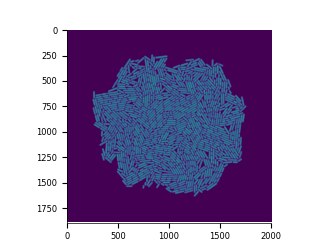

In [5]:
large_colony= tifffile.imread("../../microcolony_analysis_giant_lorentz/data/fluorescent_scenes_3D/01664.tif")
large_colony = np.pad(large_colony, ((0,0),(200,200),(200,200)))
lorentz_psf_3D = tifffile.imread("../../figures/figure_1_separate/lorentz_psf_50nm_pix_size.tiff")
plt.imshow(large_colony.sum(axis=0))

In [6]:
large_colony.shape

(18, 1890, 2005)

In [7]:
PSF_size = 2001
lorentz_fit_params = np.load("../../figures/figure_1_separate/popts.npy")
old_offsets = lorentz_fit_params[:,-1]
lorentz_fit_params[:,-1] = calculate_new_offset(old_PSF_size=lorentz_psf_3D.shape[1], new_PSF_size=1500, old_offset=old_offsets)
lorentz_fit_params[:,1] = PSF_size/2

In [8]:
x = np.linspace(0, PSF_size-1, PSF_size)
y = np.linspace(0, PSF_size-1, PSF_size)
x, y = np.meshgrid(x, y)
    
# Generate data from the optimal parameters
large_PSF_3D_expanded = []
for popt in lorentz_fit_params:
    lorentzian_PSF = lorentzian_DoG((x, y), *popt)
    large_PSF_3D_expanded.append(
        lorentzian_PSF.reshape(PSF_size, PSF_size)
    )
large_PSF_3D_expanded = np.array(large_PSF_3D_expanded)

In [9]:
lorentz_psf_3D_conv = large_PSF_3D_expanded[25-large_colony.shape[0]//2:25+large_colony.shape[0]//2,:,:]
lorentz_psf_3D_conv.shape

(18, 2001, 2001)

In [10]:
post_conv_layer_scaling = lorentz_psf_3D_conv.sum(axis=(1,2))
lorentz_psf_3D_conv_rescaled = []
for i in lorentz_psf_3D_conv:
    j = i - i.min()
    j = j / j.sum()
    lorentz_psf_3D_conv_rescaled.append(j)
lorentz_psf_3D_conv_rescaled = np.array(lorentz_psf_3D_conv_rescaled)

In [11]:
conv_colony_3D = np.array([convolve_rescale(colony_layer.astype(float), PSF_layer, 1, False) for colony_layer, PSF_layer in zip(tqdm(large_colony), lorentz_psf_3D_conv_rescaled)])

  0%|          | 0/18 [00:00<?, ?it/s]

In [12]:
conv_colony_3D_rescale = np.array([x*y for x, y in zip(conv_colony_3D, post_conv_layer_scaling)])
conv_colony_3D_rescale_2d = conv_colony_3D_rescale.sum(axis=0)

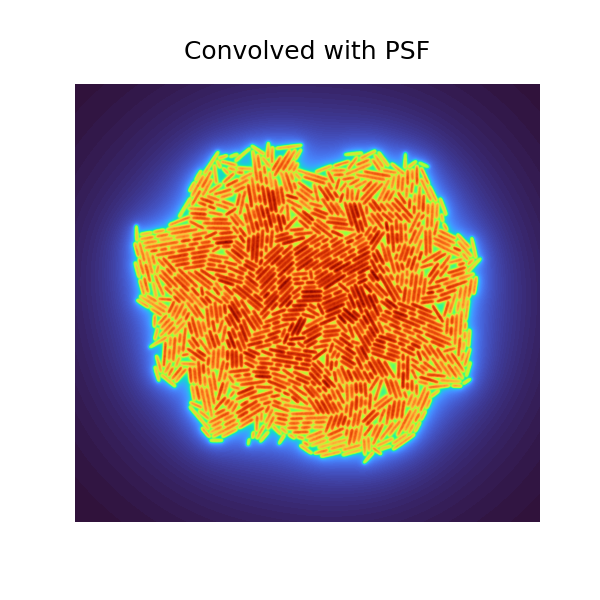

In [61]:
plt.figure(figsize=(2,2), dpi = 300)
plt.imshow(conv_colony_3D_rescale_2d, cmap="turbo")
plt.title("Convolved with PSF")
plt.axis("off")
plt.savefig("convolved.svg")
plt.show()

In [62]:
1890/2+50

995.0

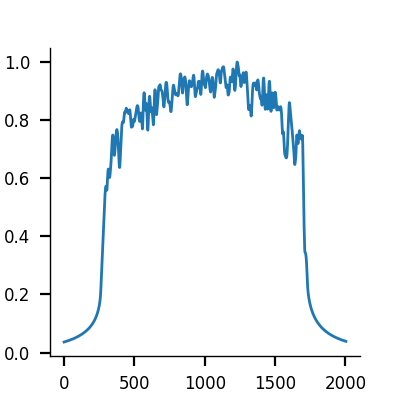

In [63]:
plt.figure(figsize=(2,2), dpi = 200)
plt.plot(conv_colony_3D_rescale_2d[895:995].mean(axis=0)/conv_colony_3D_rescale_2d[895:995].mean(axis=0).max())

In [64]:
conv_colony_2D = conv_colony_3D.sum(axis=0)
conv_colony_3D_rescale_2d = conv_colony_3D_rescale_2d + abs(conv_colony_3D_rescale_2d.min())
conv_colony_3D_rescale_2d = conv_colony_3D_rescale_2d/conv_colony_3D_rescale_2d.sum()

In [65]:
lorentz_psf_2D_deconv = lorentz_psf_3D_conv.sum(axis = 0)#[220:-220,220:-220]
lorentz_psf_2D_deconv -= lorentz_psf_2D_deconv.min()
lorentz_psf_2D_deconv /= lorentz_psf_2D_deconv.sum()

In [66]:
#plt.imshow(lorentz_psf_2D_deconv[220:-220,220:-220])

In [67]:
conv_colony_3D_rescale_2d.max()

7.876179977382307e-07

In [68]:
from skimage.restoration import richardson_lucy

In [69]:
from cucim.skimage.restoration import richardson_lucy as richardson_lucy_cuda
import cupy as cp

In [70]:
lorentz_psf_2D_deconv[900:-900,900:-900].shape

(201, 201)

In [71]:
deconv_img_lorentz = richardson_lucy_cuda(cp.array(conv_colony_3D_rescale_2d), cp.array(lorentz_psf_2D_deconv[900:-900,900:-900]), 200)

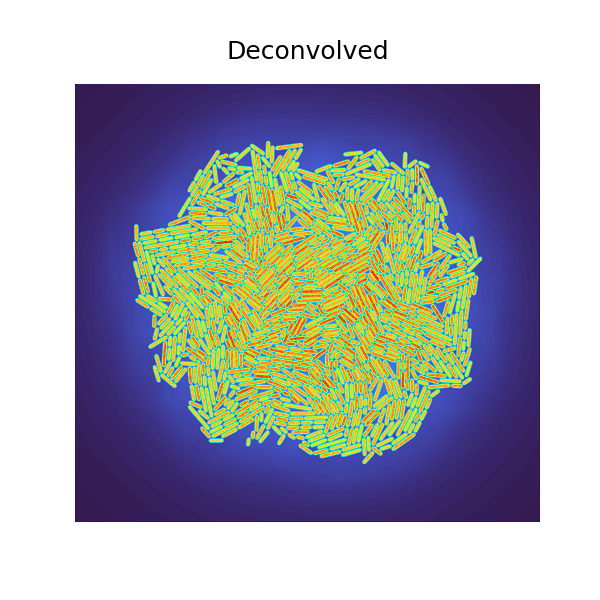

In [72]:
plt.figure(figsize=(2,2), dpi = 300)
plt.imshow(deconv_img_lorentz.get(), cmap="turbo")
plt.axis("off")
plt.title("Deconvolved")
plt.savefig("deconvolved.svg")
plt.show()

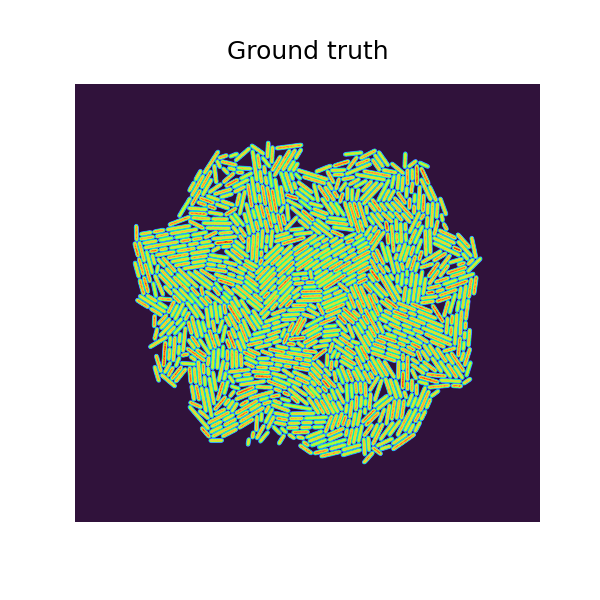

In [73]:
from skimage.filters import gaussian
plt.figure(figsize=(2,2), dpi = 300)
plt.imshow( gaussian(large_colony.sum(axis=0), 1), cmap="turbo")
plt.axis("off")
plt.title("Ground truth")
plt.savefig("ground_truth.svg")
plt.show()

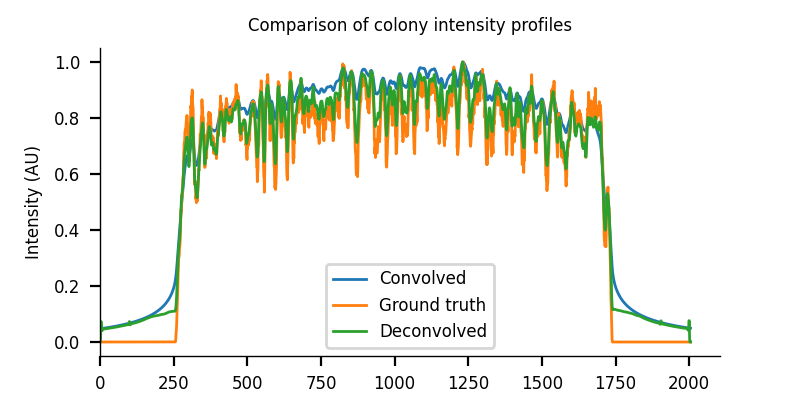

In [76]:
plt.figure(figsize=(4,2), dpi = 200)
plt.plot(conv_colony_3D_rescale_2d[800:1000].mean(axis=0)/conv_colony_3D_rescale_2d[800:1000].mean(axis=0).max(), label = "Convolved")
plt.plot(large_colony.sum(axis=0)[800:1000].mean(axis=0)/large_colony.sum(axis=0)[800:1000].mean(axis=0).max(), label = "Ground truth")
plt.plot(deconv_img_lorentz.get()[800:1000].mean(axis=0)/deconv_img_lorentz.get()[800:1000].mean(axis=0).max(), label = "Deconvolved")
plt.xlim(0,)
plt.legend()
plt.title("Comparison of colony intensity profiles")
plt.xlabel("Distance (pixels)")
plt.ylabel("Intensity (AU)")
plt.savefig("profile_comparison.svg")

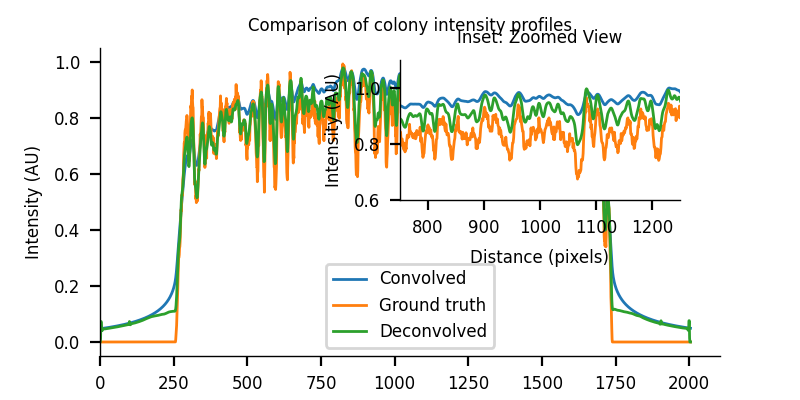

In [78]:
plt.figure(figsize=(4, 2), dpi=200)
plt.plot(conv_colony_3D_rescale_2d[800:1000].mean(axis=0)/conv_colony_3D_rescale_2d[800:1000].mean(axis=0).max(), label="Convolved")
plt.plot(large_colony.sum(axis=0)[800:1000].mean(axis=0)/large_colony.sum(axis=0)[800:1000].mean(axis=0).max(), label="Ground truth")
plt.plot(deconv_img_lorentz.get()[800:1000].mean(axis=0)/deconv_img_lorentz.get()[800:1000].mean(axis=0).max(), label="Deconvolved")
plt.xlim(0,)
plt.legend()
plt.title("Comparison of colony intensity profiles")
plt.xlabel("Distance (pixels)")
plt.ylabel("Intensity (AU)")

# Inset plot
inset_ax = plt.axes([0.5, 0.5, 0.35, 0.35]) # x, y, width, height in figure coordinate
inset_ax.plot(conv_colony_3D_rescale_2d[750:1250].mean(axis=0)/conv_colony_3D_rescale_2d[750:1250].mean(axis=0).max(), label="Convolved")
inset_ax.plot(large_colony.sum(axis=0)[750:1250].mean(axis=0)/large_colony.sum(axis=0)[750:1250].mean(axis=0).max(), label="Ground truth")
inset_ax.plot(deconv_img_lorentz.get()[750:1250].mean(axis=0)/deconv_img_lorentz.get()[750:1250].mean(axis=0).max(), label="Deconvolved")
inset_ax.set_xlim(750, 1250)
inset_ax.set_ylim(0.6, 1.1)
inset_ax.set_title("Inset: Zoomed View")
inset_ax.set_xlabel("Distance (pixels)")
inset_ax.set_ylabel("Intensity (AU)")
plt.savefig("profile_comparison.svg")

In [32]:
import seaborn as sns
synth_data = pd.read_pickle("../../microcolony_analysis_giant_lorentz/cell_data_giant_lorentz.pickle").sample(frac = 0.002, random_state=4)

synth_data['abs_diff'] = (synth_data['True CV'] - synth_data['Deconvolved CV real PSF']).abs()

# Filter rows where the absolute difference is less than or equal to 0.1
synth_data = synth_data[synth_data['abs_diff'] <= 0.1]

# Optionally, drop the 'abs_diff' column if you don't need it anymore
synth_data = synth_data.drop(columns=['abs_diff'])

In [33]:
synth_data['abs_diff'] = (synth_data['True CV'] - synth_data['Deconvolved CV real PSF']).abs()

# Filter rows where the absolute difference is less than or equal to 0.1
synth_data = synth_data[synth_data['abs_diff'] <= 0.1]

# Optionally, drop the 'abs_diff' column if you don't need it anymore
synth_data = synth_data.drop(columns=['abs_diff'])

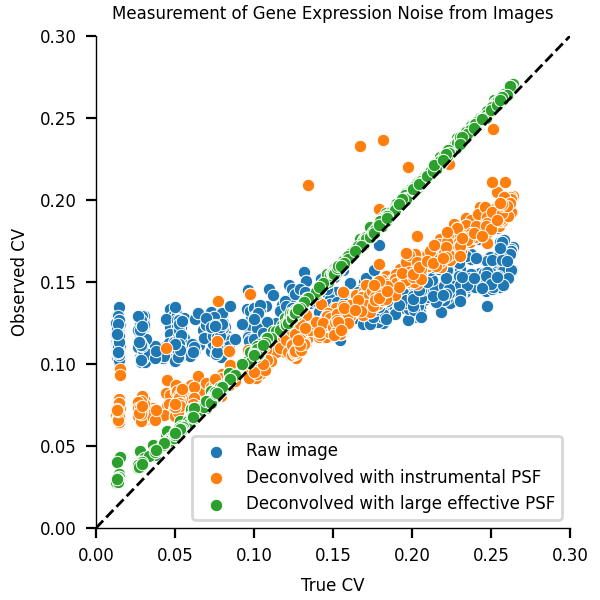

In [39]:
fig, ax = plt.subplots(figsize=(3,3), dpi = 200)
sns.scatterplot(data=synth_data.query("`Colony N cells` > 200"), x="True CV", y="Observed CV", ax=ax,  s=20, label = "Raw image")  # Adjusted for size (s=20) and alpha
sns.scatterplot(data=synth_data.query("`Colony N cells` > 200"), x="True CV", y="Deconvolved CV real PSF", ax=ax,  s=20, label = "Deconvolved with instrumental PSF")
sns.scatterplot(data=synth_data.query("`Colony N cells` > 200"), x="True CV", y="Deconvolved CV large PSF", ax=ax,  s=20, label = "Deconvolved with large effective PSF")
plt.title("Measurement of Gene Expression Noise from Images")
plt.plot([0,0.7], [0,0.7], c = "k", linestyle="--")
plt.legend()
plt.xlim(0,0.3)
plt.ylim(0,0.3)
fig.subplots_adjust(left=0.16, right=0.95, top = 0.94, bottom = 0.12)
plt.savefig("CV_scatter.svg")

In [40]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '../../SyMBac')
sys.path.insert(1, '../../microcolony_analysis_giant_lorentz/')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar
import tifffile
from skimage.transform import rotate
from skimage.transform import rescale
import scienceplots
from seaborn import move_legend
from copy import deepcopy
from matplotlib.colors import LogNorm
plt.style.use('nature')

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
from matplotlib.colors import LogNorm, AsinhNorm, PowerNorm 
from tqdm.auto import tqdm
from SyMBac.drawing import raster_cell, convert_to_3D
from SyMBac.renderer import convolve_rescale, PSF_generator
import global_params_giant_colony as global_params
from glob import glob


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
def lorentzian_DoG(xdata_tuple, amplitude, xo, gamma, sigma1, sigma2, offset):
    (x, y) = xdata_tuple
    lorentz = offset + amplitude / (1 + ((x - xo) / gamma)**2 + ((y - xo) / gamma)**2)
    gaussian_term_1 = np.exp(-((x - xo)**2 + (y - xo)**2) / (2 * sigma1**2))
    gaussian_term_2 = np.exp(-((x - xo)**2 + (y - xo)**2) / (2 * sigma2**2))
    return (lorentz * (gaussian_term_1 - gaussian_term_2)).ravel()

In [42]:
def calculate_new_offset(old_PSF_size, new_PSF_size, old_offset):
    area_ratio = (new_PSF_size ** 2) / (old_PSF_size ** 2)
    new_offset = old_offset / area_ratio
    return new_offset

In [50]:
large_colony= tifffile.imread("../../microcolony_analysis_giant_lorentz/data/fluorescent_scenes_3D/01664.tif")
large_colony = np.pad(large_colony, ((0,0),(200,200),(200,200)))
lorentz_psf_3D = tifffile.imread("../../figures/figure_1_separate/lorentz_psf_50nm_pix_size.tiff")


In [55]:
if not glob("colonies_convolved.p*"):
    colonies_convolved = []
    for PSF_size in np.arange(50,1200+600,250):
        lorentz_fit_params = np.load("../../figures/figure_1_separate/popts.npy")
        old_offsets = lorentz_fit_params[:,-1]
        lorentz_fit_params[:,-1] = calculate_new_offset(old_PSF_size=lorentz_psf_3D.shape[1], new_PSF_size=1500, old_offset=old_offsets)
        lorentz_fit_params[:,1] = PSF_size/2
        
        x = np.linspace(0, PSF_size-1, PSF_size)
        y = np.linspace(0, PSF_size-1, PSF_size)
        x, y = np.meshgrid(x, y)
            
        # Generate data from the optimal parameters
        large_PSF_3D_expanded = []
        for popt in lorentz_fit_params:
            lorentzian_PSF = lorentzian_DoG((x, y), *popt)
            large_PSF_3D_expanded.append(
                lorentzian_PSF.reshape(PSF_size, PSF_size)
            )
        large_PSF_3D_expanded = np.array(large_PSF_3D_expanded)
        
        lorentz_psf_3D_conv = large_PSF_3D_expanded[large_PSF_3D_expanded.shape[0]//2 - large_colony.shape[0]//2:large_PSF_3D_expanded.shape[0]//2+large_colony.shape[0]//2,:,:]
        lorentz_psf_3D_conv.shape
        
        post_conv_layer_scaling = lorentz_psf_3D_conv.sum(axis=(1,2))
        lorentz_psf_3D_conv_rescaled = []
        for i in lorentz_psf_3D_conv:
            #j = i - i.min()
            j = i / i.sum()
            lorentz_psf_3D_conv_rescaled.append(j)
        lorentz_psf_3D_conv_rescaled = np.array(lorentz_psf_3D_conv_rescaled)
        
        conv_colony_3D = np.array([convolve_rescale(colony_layer.astype(float), PSF_layer, 1, False) for colony_layer, PSF_layer in zip(tqdm(large_colony), lorentz_psf_3D_conv_rescaled)])
        plt.figure(figsize=(15,5))
        plt.imshow(conv_colony_3D.sum(axis=0), cmap="turbo", norm = LogNorm())
        plt.show()
        colonies_convolved.append(conv_colony_3D)
else:
    colonies_convolved = pickle.load(open("colonies_convolved.p", 'rb'))

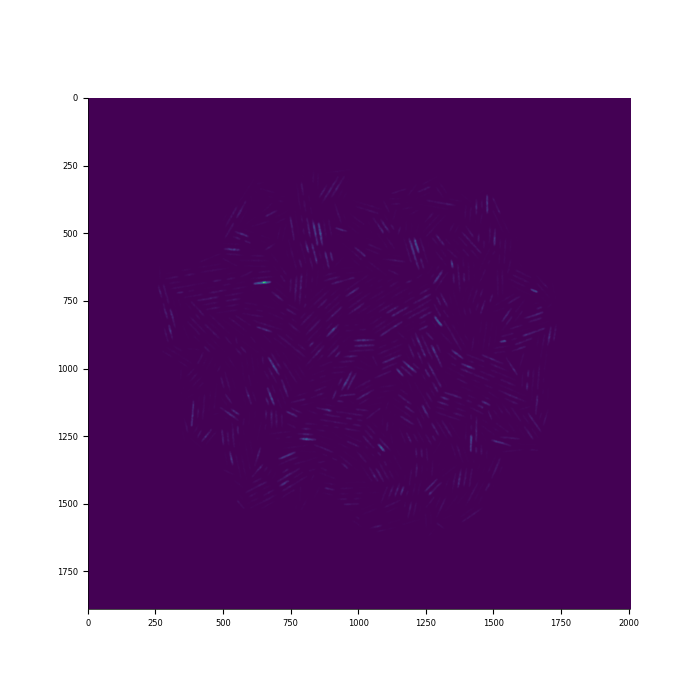

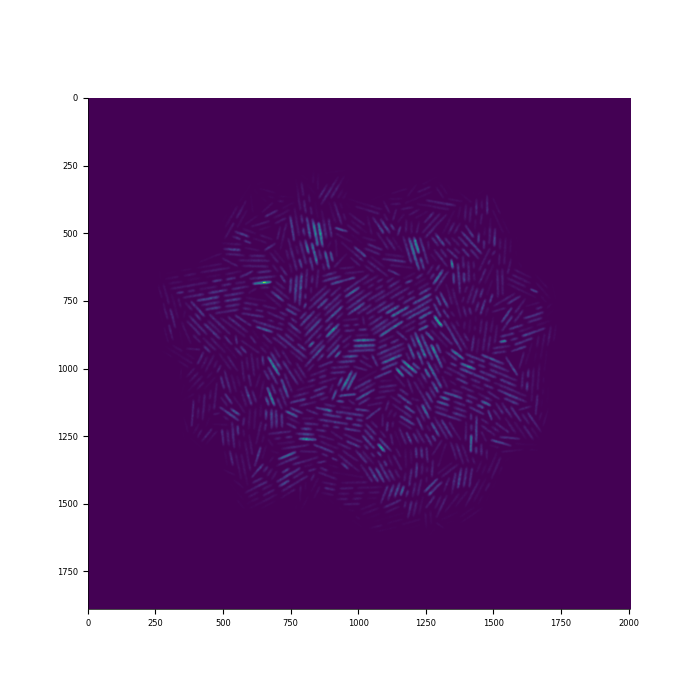

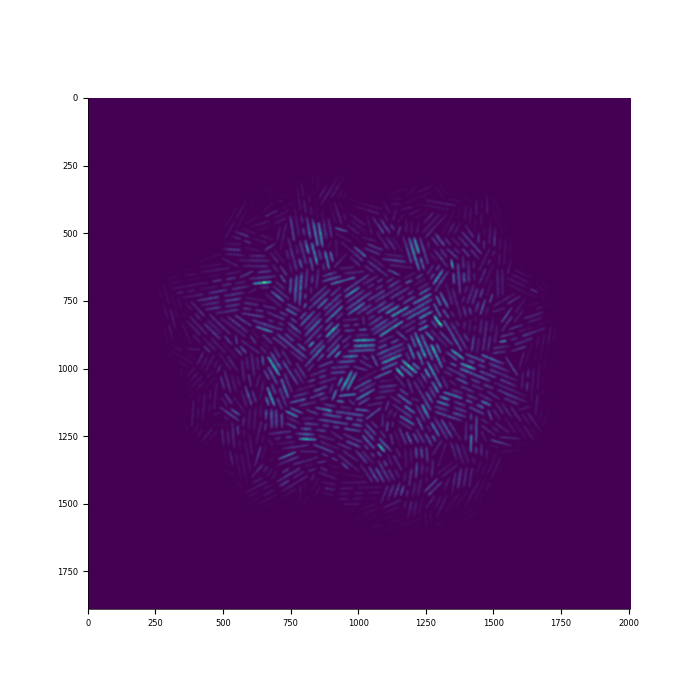

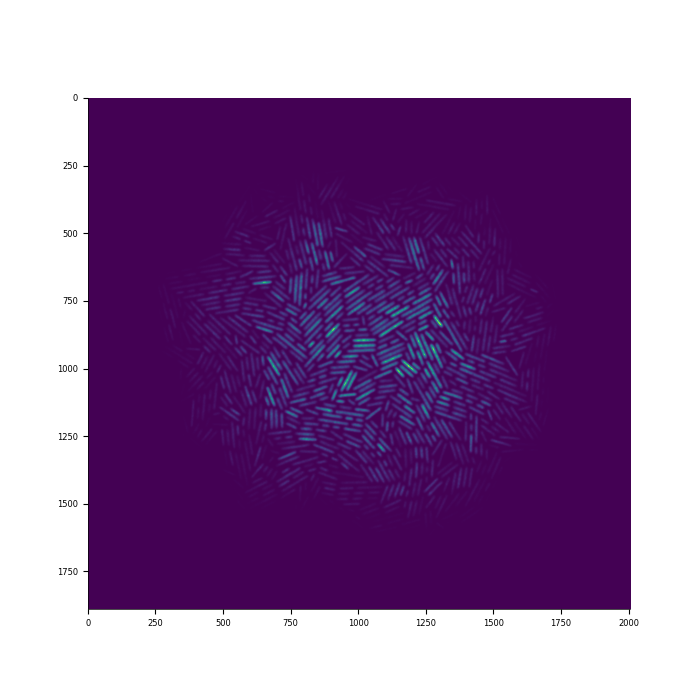

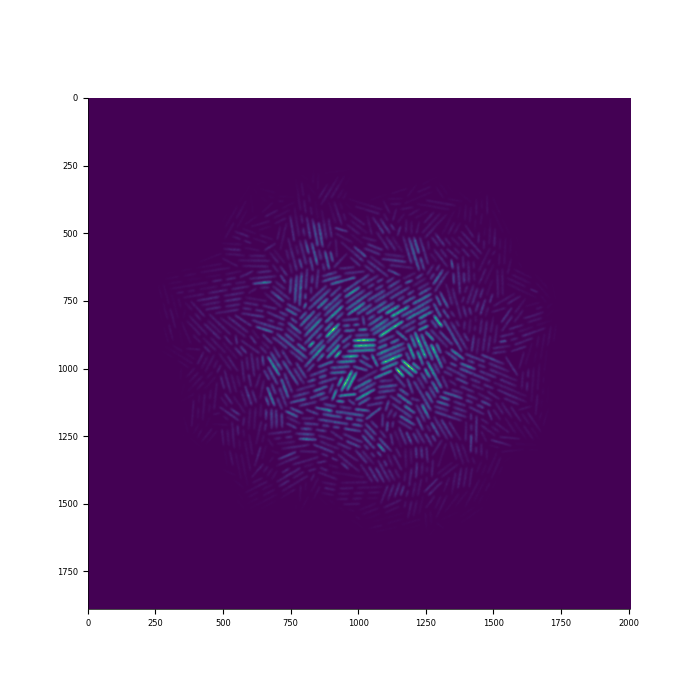

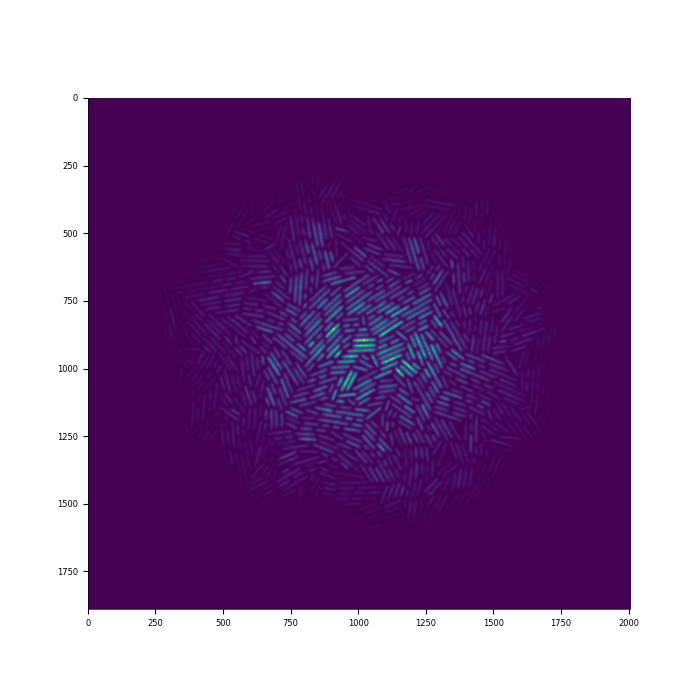

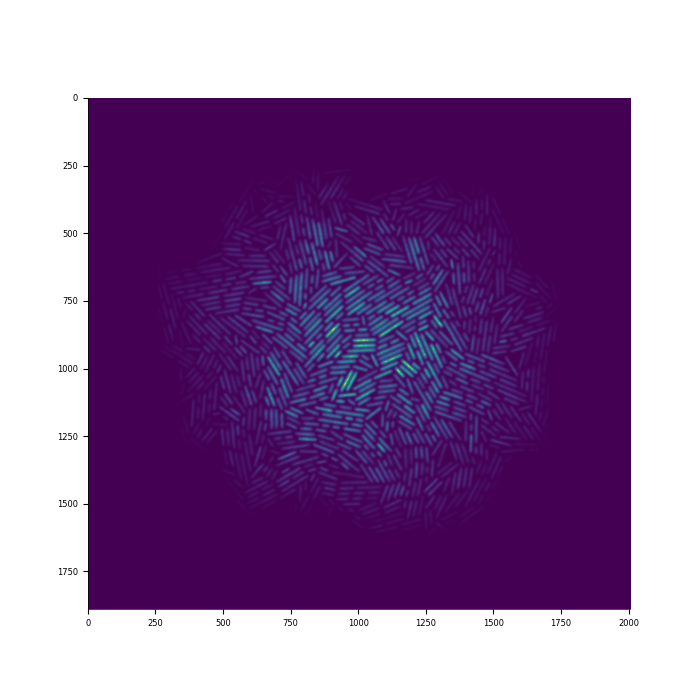

In [56]:
for colony in colonies_convolved:
    plt.figure(figsize=(7,7))
    plt.imshow(np.exp(colony.sum(axis=0)), )
    plt.show()

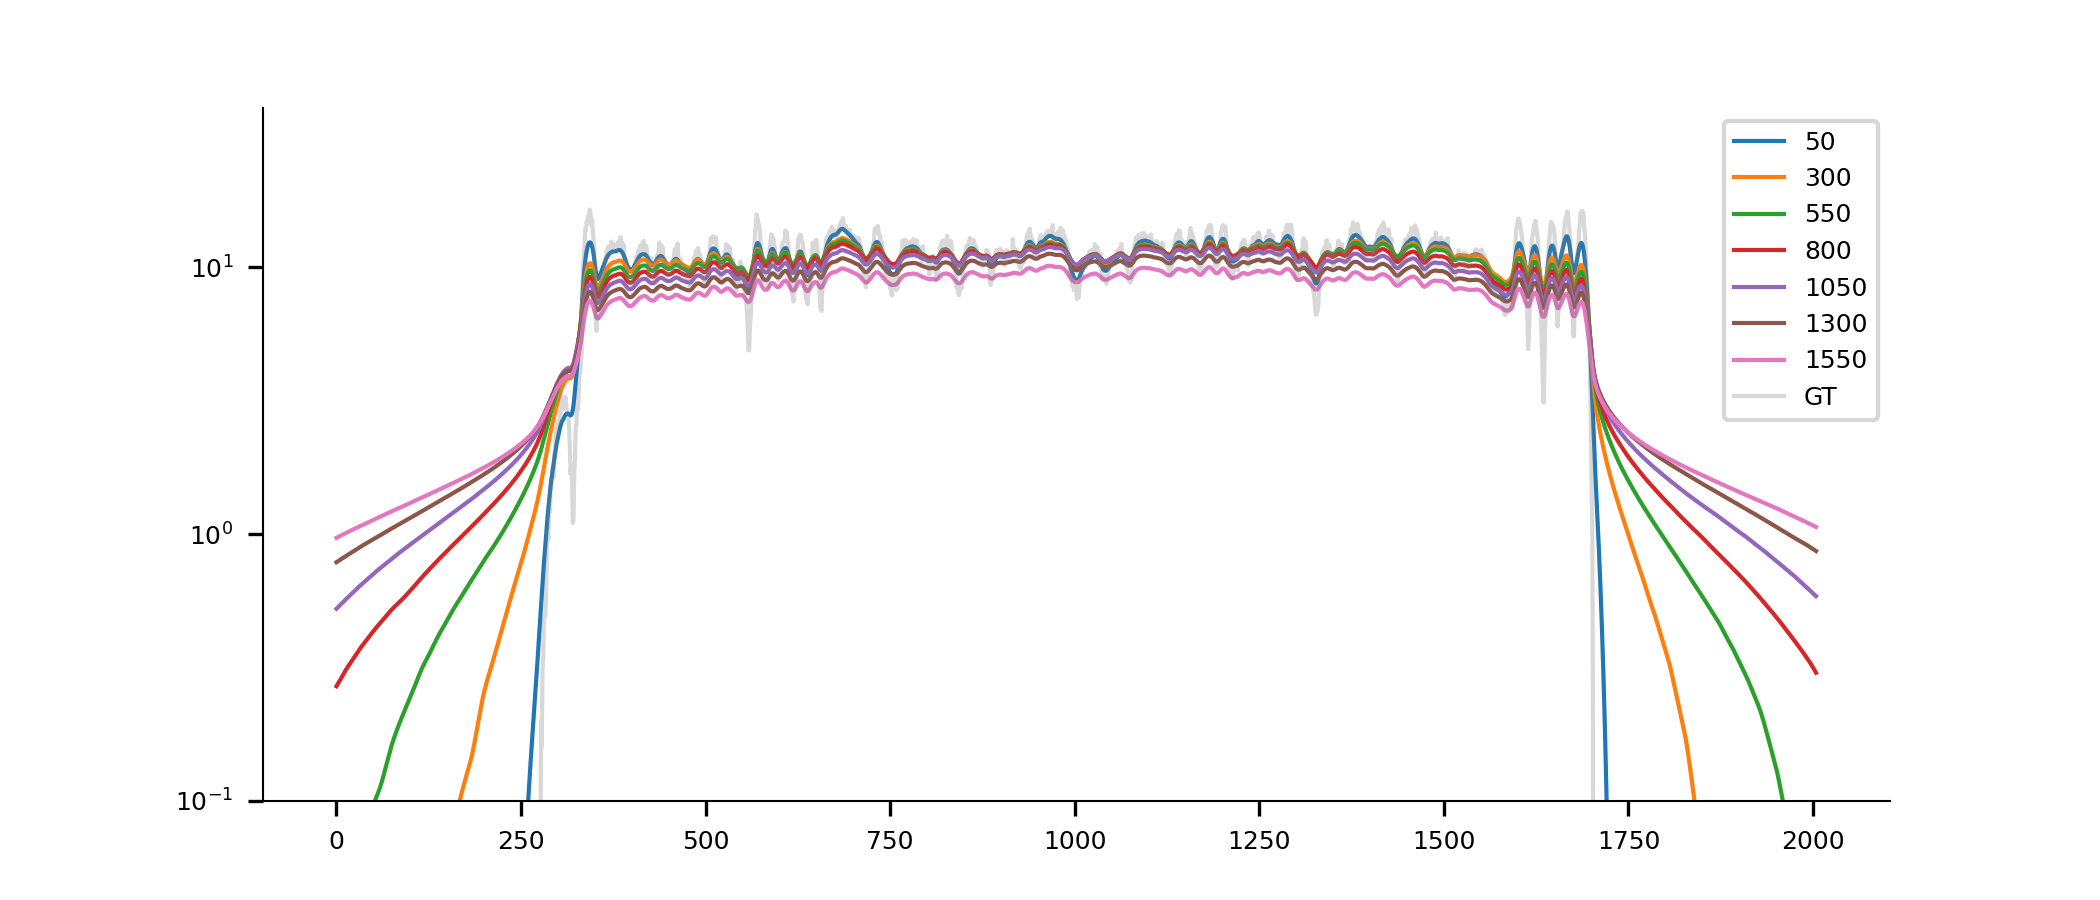

In [57]:
plt.figure(figsize=(7,3), dpi = 300)
for colony, PSF_size in zip(colonies_convolved, np.arange(50,1200+600,250)):
    plt.plot(colony.sum(axis=0)[950:1050,:].mean(axis=0), label = PSF_size)
    plt.legend()
plt.plot(large_colony.sum(axis=0)[950:1050,:].mean(axis=0), label = "GT", alpha = 0.3)
plt.yscale("log")
plt.ylim(0.1,)
plt.legend()
plt.show()


In [58]:
def calculate_radial_average(array, center=None):
    # Determine the center
    if center is None:
        center = (np.array(array.shape) / 2).astype(int)
    
    y, x = np.indices((array.shape))
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    r = r.astype(int)

    # Bin the data on radius
    tbin = np.bincount(r.ravel(), array.ravel()) # Sum for each radius
    nr = np.bincount(r.ravel()) # Number of pixels in each radius bin
    radial_profile = tbin / nr

    return radial_profile

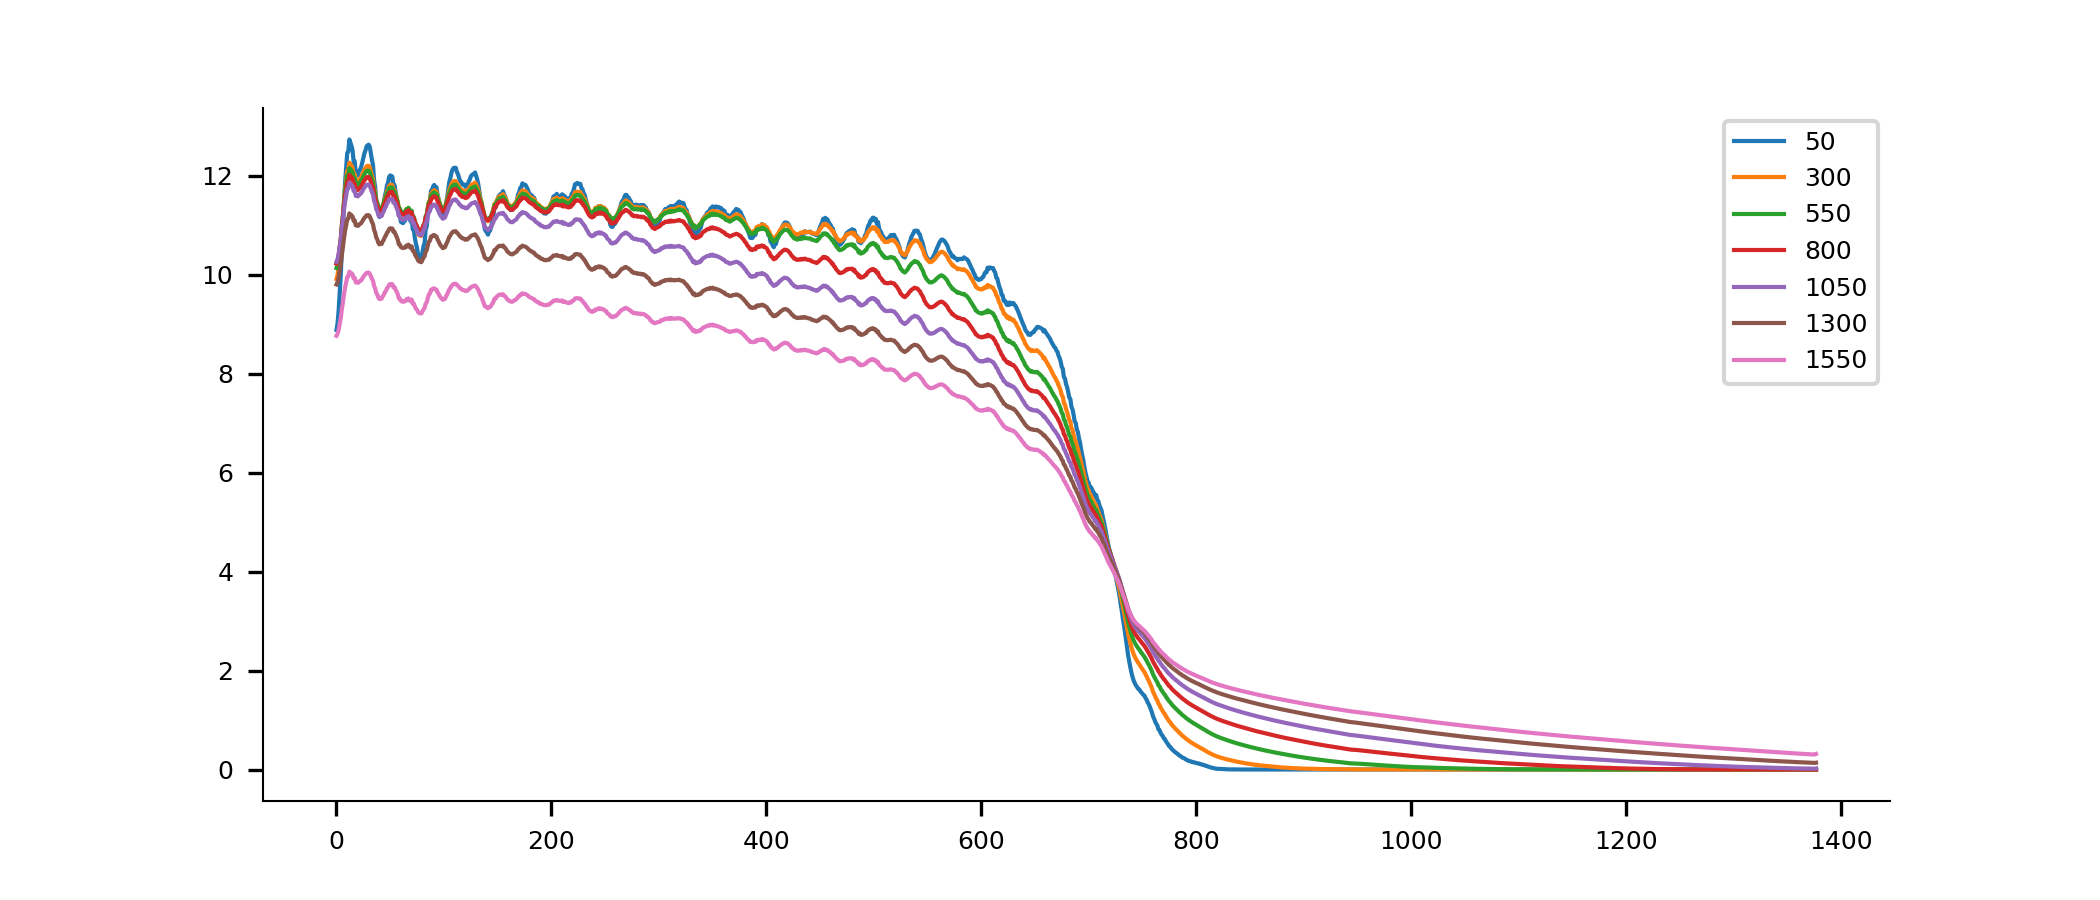

In [59]:
plt.figure(figsize=(7,3), dpi = 300)
for colony, PSF_size in zip(colonies_convolved, np.arange(50,1200+600,250)):
    plt.plot((
        calculate_radial_average(colony.sum(axis=0))
    ), label = PSF_size)
    plt.legend()
plt.show()
